In [ ]:
from Bio import PDB
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from Bio.PDB import PDBParser
from Bio.PDB.Polypeptide import three_to_one
from Bio.SVDSuperimposer import SVDSuperimposer
from Bio.PDB.Structure import Structure
from Bio.PDB.PDBExceptions import PDBConstructionWarning
from Bio.PDB.PDBIO import PDBIO
import warnings
import seaborn as sns

%matplotlib inline

# Suppress PDB construction warnings
warnings.simplefilter('ignore', PDBConstructionWarning)

# Functions #

In [76]:
def import_final_models(pdb_file_path):
    # Create a list to store the final models
    final_models = []

    # Create a PDBParser object
    parser = PDB.PDBParser()

    # Parse the PDB file
    structure = parser.get_structure('pdb', pdb_file_path)

    # Get the base directory path
    base_directory = os.path.dirname(pdb_file_path)

    # Create the 'content' directory if it doesn't exist
    content_directory = os.path.join(base_directory, 'content')
    os.makedirs(content_directory, exist_ok=True)

    # Iterate over the models (states) in the structure
    for model in structure.get_models():
        # Create a new structure with only the current model
        model_structure = PDB.Structure.Structure(model.id)
        model_structure.add(model)

        # Generate the output filename for the current model
        output_file_name = os.path.join(content_directory, f"model_{model.id}.pdb")

        # Save the current model as a separate PDB file
        pdb_io = PDB.PDBIO()
        pdb_io.set_structure(model_structure)
        pdb_io.save(output_file_name)

        # Append the current model to the list of final models
        output = parser.get_structure('model_structure', output_file_name)
        final_models.append(output)

    return final_models

In [ ]:
# Function to align a model structure onto a native structure
def align(native, model, atom_types = ["CA"]) -> SVDSuperimposer:
    """
    Aligns a model structure onto a native structure
    Using the atom types listed in `atom_types`.
    """

    # A long one-liner that gets the one-letter amino acid representation for each residue in a structure,
    # then joins those letters into one long string.
    native_seq = "".join([ three_to_one(r.resname) for r in native.get_residues()])
    model_seq = "".join([ three_to_one(r.resname) for r in model.get_residues()])

    assert len(model_seq) == len(native_seq), "The sequences should be of identical length."


    native_coords = [ a.coord for a in native[0].get_atoms() if  a.name in atom_types ]
    model_coords = [ a.coord for a in model[0].get_atoms() if  a.name in atom_types ]

    si = SVDSuperimposer()
    si.set(np.array(native_coords), np.array(model_coords))
    si.run() # Run the SVD alignment

    return si

In [78]:
def import_pdb_files(file_paths):
    structures = []
    for file_path in file_paths:
        structure_id = os.path.splitext(os.path.basename(file_path))[0]
        structure = PDB.PDBParser().get_structure(structure_id, file_path)
        structures.append(structure)
    return structures


In [79]:
def generate_file_paths(base_path, base_name, start_num, end_num):
    file_paths = []
    for num in range(start_num, end_num + 1):
        file_name = f"{base_name}{num:04}.pdb"  # Pad the number with leading zeros
        file_path = os.path.join(base_path, file_name)
        file_paths.append(file_path)
    return file_paths

In [80]:
def concatenate_dataframes(df1, df2, df3):
    concatenated_df = pd.concat([df1, df2, df3], axis=0)
    return concatenated_df

def concatenate_dataframe_and_dict(dict1, dict2, dict3):
    dict_dfs = [pd.DataFrame.from_dict(dict1, orient='index').T,
                pd.DataFrame.from_dict(dict2, orient='index').T,
                pd.DataFrame.from_dict(dict3, orient='index').T]
    concatenated_df = pd.concat(dict_dfs, axis=0)
    return concatenated_df

In [81]:
def align_and_calculate_mean_rmsd(structures, final_models, atom_types, top_val=10):
    mean_rmsd_dict = {
        "end_num": end_num,
        "base_name": base_name.split("_", 1)[0],
        "min_mean_rmsd": float("inf"),
        "min_rmsd_structure": None,
    }
    all_values = []
    min_values = []
    iterrations = []

    for structure in structures:
        rmsd_values = []
        min_rmsd = float("inf")
        min_iteration = None

        for iteration, model in enumerate(final_models):
            si = align(model, structure, atom_types)
            rmsd = si.get_rms()
            rmsd_values.append(rmsd)

            if rmsd < min_rmsd:
              min_rmsd = rmsd
              min_iteration = iteration

        mean_rmsd = sum(rmsd_values) / len(rmsd_values)
        min_values.append(min_rmsd)
        iterrations.append(min_iteration)
        all_values.append(mean_rmsd)

        if mean_rmsd < mean_rmsd_dict["min_mean_rmsd"]:
            mean_rmsd_dict["min_mean_rmsd"] = mean_rmsd
            mean_rmsd_dict["min_rmsd_structure"] = structure

    data_temp = {'All': all_values,
                 'Min_Values': min_values,
                 'Iterations': iterrations}

    temp_dataframe = pd.DataFrame(data_temp)
    sorted_temp_dataframe = temp_dataframe.sort_values(by='All')
    top_rows_dataframe = sorted_temp_dataframe.head(top_val)

    list_id = [mean_rmsd_dict['base_name'] + '_' + str(mean_rmsd_dict["end_num"])] * top_val
    dict_temp = {'ID': list_id,
                 'Mean_RMSD': top_rows_dataframe['All'].values,
                 'Min_Values': top_rows_dataframe['Min_Values'].values,
                 'Best_state': top_rows_dataframe['Iterations'].values}
    df = pd.DataFrame(dict_temp)

    return mean_rmsd_dict, df

# 2JYV #

------------------------------------------------
For 10 JYV

------------------------------------------------

In [ ]:
# Specify the path to your PDB file=s
pdb_file_path = '../data/2jyv_pdbs/2jyv.pdb' 

base_path = "../data/2jyv_pdbs/10/"  
base_name = "2JYV_10_"     
start_num = 1
end_num = 10

p = PDBParser(QUIET=True)

In [83]:
file_paths = generate_file_paths(base_path, base_name, start_num, end_num)

structures = import_pdb_files(file_paths)

models = import_final_models(pdb_file_path)

In [ ]:
# Call the align_and_calculate_mean_rmsd function
mean_rmsd_info_10 , df_top_10_10 = align_and_calculate_mean_rmsd(structures, models,"CA",10)

In [85]:
df_top_10_10

,ID,Mean_RMSD,Min_Values,Best_state
0,2JYV_10,5.668796,5.376244,6
1,2JYV_10,5.845028,5.499420,4
2,2JYV_10,5.994509,5.746813,4
3,2JYV_10,6.622753,6.318227,9
4,2JYV_10,6.623281,6.377687,4
5,2JYV_10,7.292452,7.011738,0
6,2JYV_10,7.500847,7.116710,6
7,2JYV_10,7.603549,7.371781,9
8,2JYV_10,8.253253,7.962959,2
9,2JYV_10,9.473306,9.217922,3


------------------------------------------------
For 100 JYV

------------------------------------------------

In [ ]:
base_path = "../data/2jyv_pdbs/100/"  ############
base_name = "2JYV_100_"     #############
start_num = 1
end_num = 100

p = PDBParser(QUIET=True)

file_paths = generate_file_paths(base_path, base_name, start_num, end_num)

structures = import_pdb_files(file_paths)

# Call the align_and_calculate_mean_rmsd function
mean_rmsd_info_100 , df_top_10_100 = align_and_calculate_mean_rmsd(structures, models,"CA",10)

In [87]:
df_top_10_100.Best_state

0    4
1    4
2    4
3    4
4    4
5    0
6    6
7    4
8    4
9    5
Name: Best_state, dtype: int64

------------------------------------------------
For 1000 JYV

------------------------------------------------

In [ ]:
base_path = "../data/2jyv_pdbs/1000/"  ############
base_name = "2JYV_1000_"     #############
start_num = 1
end_num = 1000

p = PDBParser(QUIET=True)

file_paths = generate_file_paths(base_path, base_name, start_num, end_num)

structures = import_pdb_files(file_paths)

# Call the align_and_calculate_mean_rmsd function
mean_rmsd_info_1000 , df_top_10_1000 = align_and_calculate_mean_rmsd(structures, models,"CA",10)

In [89]:
df_top_10_1000.Best_state

0    4
1    9
2    9
3    4
4    4
5    8
6    4
7    4
8    9
9    4
Name: Best_state, dtype: int64

------------------------------------------------
Make them Dataframes

------------------------------------------------

In [90]:
df_jyv_top_10s = concatenate_dataframes(df_top_10_10,df_top_10_100,df_top_10_1000)
df_jyv_top_10s.head()

,ID,Mean_RMSD,Min_Values,Best_state
0,2JYV_10,5.668796,5.376244,6
1,2JYV_10,5.845028,5.499420,4
2,2JYV_10,5.994509,5.746813,4
3,2JYV_10,6.622753,6.318227,9
4,2JYV_10,6.623281,6.377687,4


In [91]:
df_jyv_best_rmsds = concatenate_dataframe_and_dict(mean_rmsd_info_10,mean_rmsd_info_100,mean_rmsd_info_1000)
df_jyv_best_rmsds

,end_num,base_name,min_mean_rmsd,min_rmsd_structure
0,10,2JYV,5.668796,"(((<Residue ALA het= resseq=1 icode= >, <Resi..."
0,100,2JYV,2.889797,"(((<Residue ALA het= resseq=1 icode= >, <Resi..."
0,1000,2JYV,3.067017,"(((<Residue ALA het= resseq=1 icode= >, <Resi..."


# 2MPC #

------------------------------------------------
For 10 MPC

------------------------------------------------

In [ ]:
# Specify the path to your PDB file=s
pdb_file_path = '../data/2mpc_pdbs/2mpc.pdb'

base_path = "../data/2mpc_pdbs/10/"
base_name = "2MPC_10_"
start_num = 1
end_num = 10

p = PDBParser(QUIET=True)

file_paths = generate_file_paths(base_path, base_name, start_num, end_num)

structures = import_pdb_files(file_paths)

models = import_final_models(pdb_file_path)

# Call the align_and_calculate_mean_rmsd function
mean_rmsd_info_10 , df_top_10_10 = align_and_calculate_mean_rmsd(structures, models,"CA",10)

------------------------------------------------
For 100 MPC

------------------------------------------------

In [ ]:
base_path = "../data/2mpc_pdbs/100/"
base_name = "2MPC_100_"
start_num = 1
end_num = 100

p = PDBParser(QUIET=True)

file_paths = generate_file_paths(base_path, base_name, start_num, end_num)

structures = import_pdb_files(file_paths)

# models = import_final_models(pdb_file_path)

# Call the align_and_calculate_mean_rmsd function
mean_rmsd_info_100 , df_top_10_100 = align_and_calculate_mean_rmsd(structures, models,"CA",10)

------------------------------------------------
For 1000 MPC

------------------------------------------------

In [ ]:
base_path = "../data/2mpc_pdbs/1000/"
base_name = "2MPC_1000_"
start_num = 1
end_num = 1000

p = PDBParser(QUIET=True)

file_paths = generate_file_paths(base_path, base_name, start_num, end_num)

structures = import_pdb_files(file_paths)

# models = import_final_models(pdb_file_path)

# Call the align_and_calculate_mean_rmsd function
mean_rmsd_info_1000 , df_top_10_1000 = align_and_calculate_mean_rmsd(structures, models,"CA",10)

------------------------------------------------
Make them Dataframes

------------------------------------------------

In [95]:
df_mpc_top_10s = concatenate_dataframes(df_top_10_10,df_top_10_100,df_top_10_1000)
df_mpc_best_rmsds = concatenate_dataframe_and_dict(mean_rmsd_info_10,mean_rmsd_info_100,mean_rmsd_info_1000)

# 2MS8 #

In [ ]:
# Specify the path to your PDB file=s
pdb_file_path = '../data/2ms8_pdbs/2ms8.pdb'

base_path = "../data/2ms8_pdbs/10/"
base_name = "2MS8_10_"
start_num = 1
end_num = 10

p = PDBParser(QUIET=True)

file_paths = generate_file_paths(base_path, base_name, start_num, end_num)

structures = import_pdb_files(file_paths)

models = import_final_models(pdb_file_path)

# Call the align_and_calculate_mean_rmsd function
mean_rmsd_info_10 , df_top_10_10 = align_and_calculate_mean_rmsd(structures, models,"CA",10)


base_path = "../data/2ms8_pdbs/100/"
base_name = "2MS8_100_"
start_num = 1
end_num = 100

# p = PDBParser(QUIET=True)

file_paths = generate_file_paths(base_path, base_name, start_num, end_num)

structures = import_pdb_files(file_paths)

# models = import_final_models(pdb_file_path)

# Call the align_and_calculate_mean_rmsd function
mean_rmsd_info_100 , df_top_10_100 = align_and_calculate_mean_rmsd(structures, models,"CA",10)


base_path = "../data/2ms8_pdbs/1000/"
base_name = "2MS8_1000_"
start_num = 1
end_num = 1000

# p = PDBParser(QUIET=True)

file_paths = generate_file_paths(base_path, base_name, start_num, end_num)

structures = import_pdb_files(file_paths)

# models = import_final_models(pdb_file_path)

# Call the align_and_calculate_mean_rmsd function
mean_rmsd_info_1000 , df_top_10_1000 = align_and_calculate_mean_rmsd(structures, models,"CA",10)

In [97]:
df_ms8_top_10s = concatenate_dataframes(df_top_10_10,df_top_10_100,df_top_10_1000)
df_ms8_best_rmsds = concatenate_dataframe_and_dict(mean_rmsd_info_10,mean_rmsd_info_100,mean_rmsd_info_1000)

In [98]:
df_ms8_jyv_mpc_top_10 = concatenate_dataframes(df_jyv_top_10s, df_mpc_top_10s, df_ms8_top_10s)
df_ms8_jyv_mpc_best_rmsds= concatenate_dataframes(df_jyv_best_rmsds,df_mpc_best_rmsds,df_ms8_best_rmsds)

In [99]:
df_ms8_jyv_mpc_best_rmsds

,end_num,base_name,min_mean_rmsd,min_rmsd_structure
0,10,2JYV,5.668796,"(((<Residue ALA het= resseq=1 icode= >, <Resi..."
0,100,2JYV,2.889797,"(((<Residue ALA het= resseq=1 icode= >, <Resi..."
0,1000,2JYV,3.067017,"(((<Residue ALA het= resseq=1 icode= >, <Resi..."
0,10,2MPC,4.744574,"(((<Residue THR het= resseq=1 icode= >, <Resi..."
0,100,2MPC,4.185632,"(((<Residue THR het= resseq=1 icode= >, <Resi..."
0,1000,2MPC,2.606431,"(((<Residue THR het= resseq=1 icode= >, <Resi..."
0,10,2MS8,7.490367,"(((<Residue GLY het= resseq=1 icode= >, <Resi..."
0,100,2MS8,4.399827,"(((<Residue GLY het= resseq=1 icode= >, <Resi..."
0,1000,2MS8,3.774262,"(((<Residue GLY het= resseq=1 icode= >, <Resi..."


# 6MWM #

In [ ]:
# Specify the path to your PDB file=s
pdb_file_path = '../data/6mwm_pdbs/6mwm.pdb'

base_path = "../data/6mwm_pdbs/10/"
base_name = "6MWM_10_"
start_num = 1
end_num = 10

p = PDBParser(QUIET=True)

file_paths = generate_file_paths(base_path, base_name, start_num, end_num)

structures = import_pdb_files(file_paths)

models = import_final_models(pdb_file_path)

# Call the align_and_calculate_mean_rmsd function
mean_rmsd_info_10 , df_top_10_10 = align_and_calculate_mean_rmsd(structures, models,"CA",10)


base_path = "../data/6mwm_pdbs/100/"
base_name = "6MWM_100_"
start_num = 1
end_num = 100

# p = PDBParser(QUIET=True)

file_paths = generate_file_paths(base_path, base_name, start_num, end_num)

structures = import_pdb_files(file_paths)

# models = import_final_models(pdb_file_path)

# Call the align_and_calculate_mean_rmsd function
mean_rmsd_info_100 , df_top_10_100 = align_and_calculate_mean_rmsd(structures, models,"CA",10)


base_path = "../data/6mwm_pdbs/1000/"
base_name = "6MWM_1000_"
start_num = 1
end_num = 1000

# p = PDBParser(QUIET=True)

file_paths = generate_file_paths(base_path, base_name, start_num, end_num)

structures = import_pdb_files(file_paths)

# models = import_final_models(pdb_file_path)

# Call the align_and_calculate_mean_rmsd function
mean_rmsd_info_1000 , df_top_10_1000 = align_and_calculate_mean_rmsd(structures, models,"CA",10)

In [101]:
df_mwm_top_10s = concatenate_dataframes(df_top_10_10,df_top_10_100,df_top_10_1000)
df_mwm_best_rmsds = concatenate_dataframe_and_dict(mean_rmsd_info_10,mean_rmsd_info_100,mean_rmsd_info_1000)

# 2MOD #

In [ ]:
def align(native, model, atom_types=["CA"]) -> SVDSuperimposer:
    """
    Aligns a model structure onto a native structure
    Using the atom types listed in `atom_types`.
    """
    # 2M0D had an extra name which three_to_one could not find. This is why we re-root it
    native_seq = "".join([three_to_one(r.resname) for r in native.get_residues() if r.resname != "ZN"])
    model_seq = "".join([three_to_one(r.resname) for r in model.get_residues() if r.resname != "ZN"])

    assert len(model_seq) == len(native_seq), "The sequences should be of identical length."

    native_coords = [a.coord for a in native[0].get_atoms() if a.name in atom_types and a.parent.resname != "ZN"]
    model_coords = [a.coord for a in model[0].get_atoms() if a.name in atom_types and a.parent.resname != "ZN"]

    si = SVDSuperimposer()
    si.set(np.array(native_coords), np.array(model_coords))
    si.run()  # Run the SVD alignment

    return si

In [ ]:
# Specify the path to your PDB file=s
pdb_file_path = '../data/2m0d_pdbs/2m0d.pdb'

base_path = "../data/2m0d_pdbs/10/"
base_name = "2M0D_10_"
start_num = 1
end_num = 10

p = PDBParser(QUIET=True)

file_paths = generate_file_paths(base_path, base_name, start_num, end_num)

structures = import_pdb_files(file_paths)

models = import_final_models(pdb_file_path)

# Call the align_and_calculate_mean_rmsd function
mean_rmsd_info_10 , df_top_10_10 = align_and_calculate_mean_rmsd(structures, models,"CA",10)


base_path = "../data/2m0d_pdbs/100/"
base_name = "2M0D_100_"
start_num = 1
end_num = 100

# p = PDBParser(QUIET=True)

file_paths = generate_file_paths(base_path, base_name, start_num, end_num)

structures = import_pdb_files(file_paths)

# models = import_final_models(pdb_file_path)

# Call the align_and_calculate_mean_rmsd function
mean_rmsd_info_100 , df_top_10_100 = align_and_calculate_mean_rmsd(structures, models,"CA",10)


base_path = "../data/2m0d_pdbs/1000/"
base_name = "2M0D_1000_"
start_num = 1
end_num = 1000

# p = PDBParser(QUIET=True)

file_paths = generate_file_paths(base_path, base_name, start_num, end_num)

structures = import_pdb_files(file_paths)

# models = import_final_models(pdb_file_path)

# Call the align_and_calculate_mean_rmsd function
mean_rmsd_info_1000 , df_top_10_1000 = align_and_calculate_mean_rmsd(structures, models,"CA",10)

In [104]:
df_m0d_top_10s = concatenate_dataframes(df_top_10_10,df_top_10_100,df_top_10_1000)
df_m0d_best_rmsds = concatenate_dataframe_and_dict(mean_rmsd_info_10,mean_rmsd_info_100,mean_rmsd_info_1000)

# Final Dataframe #

In [105]:
df_all_top_10 = concatenate_dataframes(df_ms8_jyv_mpc_top_10, df_m0d_top_10s, df_mwm_top_10s)
df_all_best_rmsds = concatenate_dataframes(df_ms8_jyv_mpc_best_rmsds,df_m0d_best_rmsds,df_mwm_best_rmsds)

In [106]:
df_all_top_10

,ID,Mean_RMSD,Min_Values,Best_state
0,2JYV_10,5.668796,5.376244,6
1,2JYV_10,5.845028,5.499420,4
2,2JYV_10,5.994509,5.746813,4
3,2JYV_10,6.622753,6.318227,9
4,2JYV_10,6.623281,6.377687,4
...,...,...,...,...
5,6MWM_1000,6.264626,5.819298,7
6,6MWM_1000,6.669287,6.417001,16
7,6MWM_1000,6.753101,6.477314,15
8,6MWM_1000,6.819984,6.616920,1


## Barplot for best RMSD's ##

In [107]:
df_all_best_rmsds

,end_num,base_name,min_mean_rmsd,min_rmsd_structure
0,10,2JYV,5.668796,"(((<Residue ALA het= resseq=1 icode= >, <Resi..."
0,100,2JYV,2.889797,"(((<Residue ALA het= resseq=1 icode= >, <Resi..."
0,1000,2JYV,3.067017,"(((<Residue ALA het= resseq=1 icode= >, <Resi..."
0,10,2MPC,4.744574,"(((<Residue THR het= resseq=1 icode= >, <Resi..."
0,100,2MPC,4.185632,"(((<Residue THR het= resseq=1 icode= >, <Resi..."
0,1000,2MPC,2.606431,"(((<Residue THR het= resseq=1 icode= >, <Resi..."
0,10,2MS8,7.490367,"(((<Residue GLY het= resseq=1 icode= >, <Resi..."
0,100,2MS8,4.399827,"(((<Residue GLY het= resseq=1 icode= >, <Resi..."
0,1000,2MS8,3.774262,"(((<Residue GLY het= resseq=1 icode= >, <Resi..."
0,10,2M0D,5.0174,"(((<Residue MET het= resseq=1 icode= >, <Resi..."


In [108]:
df_all_best_rmsds['min_mean_rmsd'] = df_all_best_rmsds['min_mean_rmsd'].astype(float)
df_all_best_rmsds['end_num'] = df_all_best_rmsds['end_num'].astype(str)

# Define the color palette
color_palette = sns.color_palette("Set1")

In [109]:
def plot_barplot(df_all_best_rmsds, base_name):
    filtered_df = df_all_best_rmsds[df_all_best_rmsds['base_name'] == base_name]
    # Create the bar plot using the color palette
    plt.bar(filtered_df.end_num, filtered_df.min_mean_rmsd, color=color_palette,width = 0.4)

    # Set the labels for x and y axes
    plt.xlabel('End Num')
    plt.ylabel('Min Mean RMSD')

    # Set the title
    plt.title(f'Bar Plot for Base Name: {base_name}')

    # Show the plot
    plt.show()


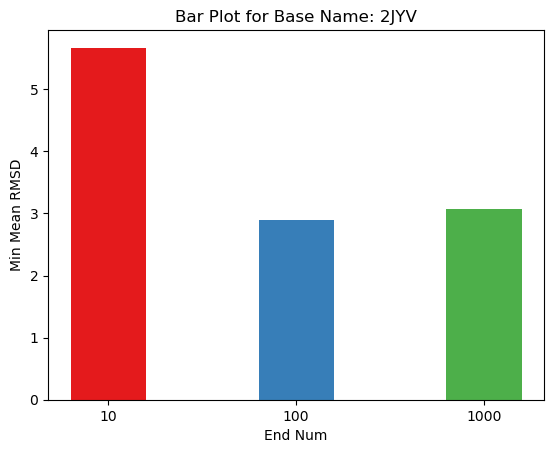

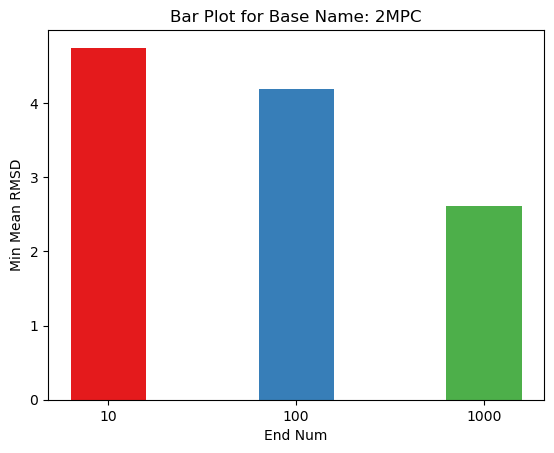

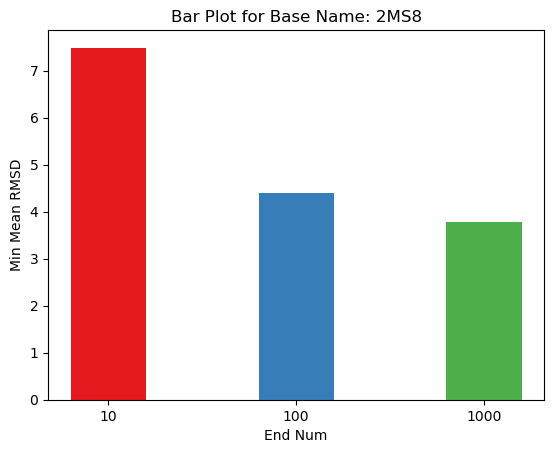

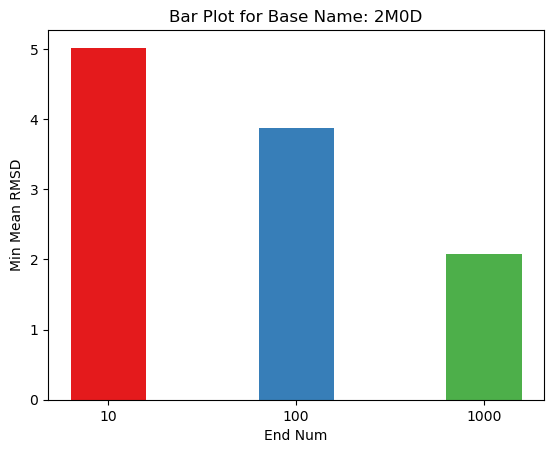

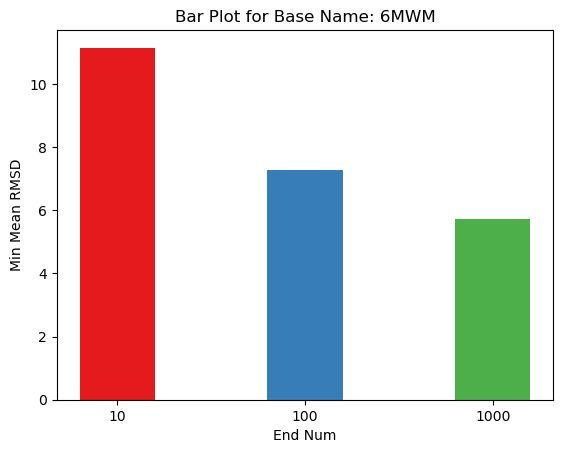

In [110]:
for protein in df_all_best_rmsds.base_name.unique():
    plot_barplot(df_all_best_rmsds, protein)

## Plot for top 10 ##

In [111]:
color_palette = sns.color_palette("Set2")

In [112]:
def barplot_top_10(df, names):
    filtered_df = df[df['ID'].isin(names)]  # Filter the DataFrame for the specified base names
    grouped_df = filtered_df.groupby('ID')['Mean_RMSD'].mean().reset_index()  # Calculate the mean of Mean_RMSD for each base name

    base_names = grouped_df['ID'].values.astype(str)
    min_mean_rmsd = grouped_df['Mean_RMSD'].values.astype(float)

    plt.bar(base_names, min_mean_rmsd, color=color_palette, width=0.4)

    plt.xlabel('Base Names')
    plt.ylabel('Mean top 10 RMSD')

    plt.title('Mean of top 10 RMSD for Base Names'+str(names[0][:4]))
    plt.show()


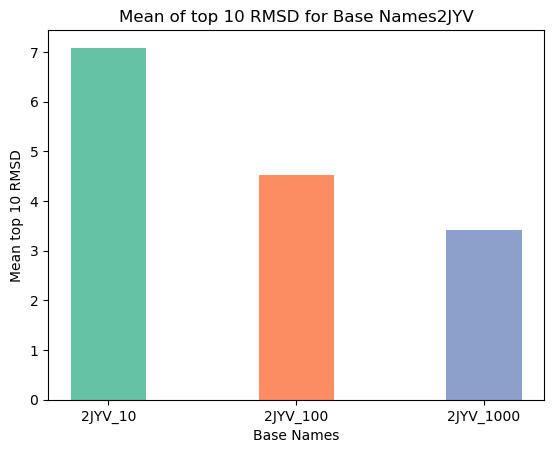

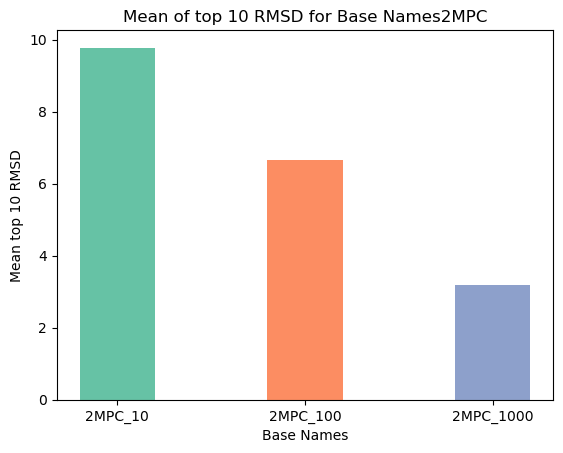

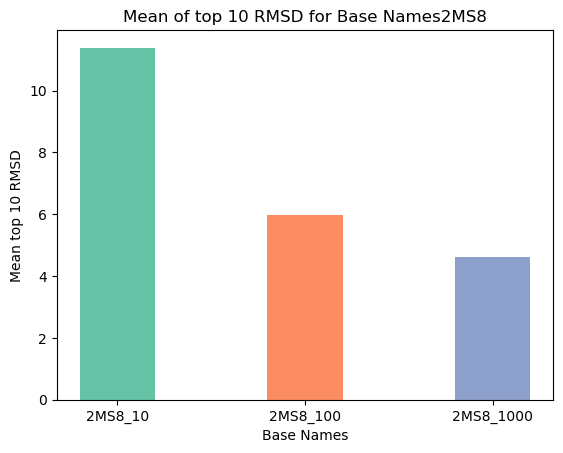

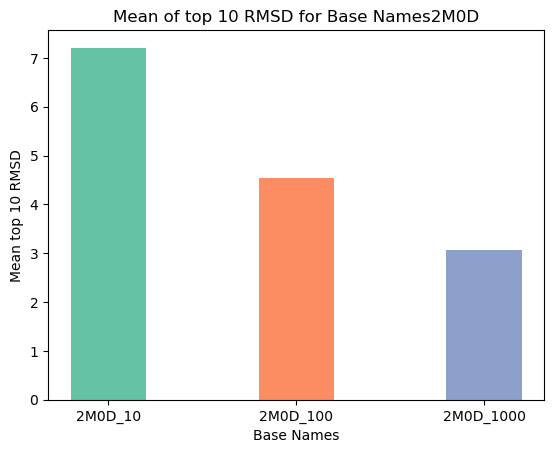

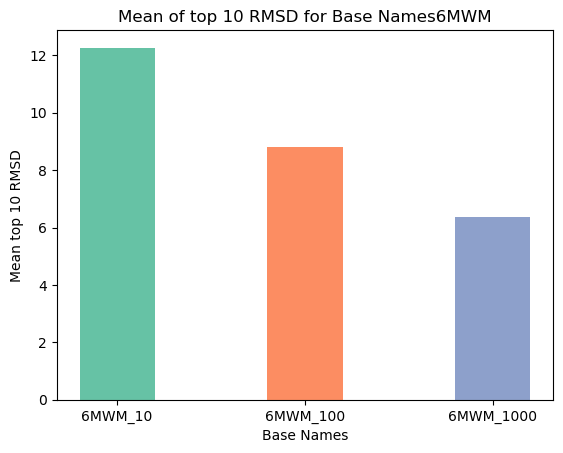

In [113]:
names_list = df_all_top_10.ID.unique()

for triada in range(1,5+1):
  barplot_top_10(df_all_top_10,names_list[(triada-1)*3:triada*3])


## Export to CSV ##

In [ ]:
df_all_top_10.to_csv('../data/top_10.csv', index=False)
df_all_best_rmsds.to_csv('../data/top_rmsd.csv', index=False)